In [25]:
"""
Comprehensive Clustering and Dimensionality Reduction Analysis
Hospital Readmission Project - Track 5

Includes:
- K-Means, Hierarchical, DBSCAN clustering
- PCA, t-SNE, UMAP dimensionality reduction
- Cluster evaluation and profiling
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import (
    silhouette_score, 
    davies_bouldin_score, 
    calinski_harabasz_score,
    silhouette_samples
)
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

In [26]:
# Try to import UMAP (optional)
try:
    from umap import UMAP
    UMAP_AVAILABLE = True
except ImportError:
    UMAP_AVAILABLE = False
    print("⚠️  UMAP not available. Install with: pip install umap-learn")

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

In [27]:
# =========================
# 1. LOAD DATA
# =========================
print("="*60)
print("LOADING DATA")
print("="*60)

df = pd.read_csv("data/diabetic_data.csv")
print(f"Dataset shape: {df.shape}")

LOADING DATA
Dataset shape: (101766, 50)


In [28]:
# =========================
# 2. FEATURE SELECTION
# =========================
print("\n" + "="*60)
print("FEATURE SELECTION FOR CLUSTERING")
print("="*60)

# Focus on features that define patient profiles
numeric_features = [
    "time_in_hospital",
    "num_lab_procedures",
    "num_procedures",
    "num_medications",
    "number_outpatient",
    "number_emergency",
    "number_inpatient",
    "number_diagnoses"
]

categorical_features = [
    "race",
    "gender",
    "age",
    "admission_type_id",
    "discharge_disposition_id",
    "admission_source_id",
    "max_glu_serum",
    "A1Cresult",
    "diabetesMed"
]

# Optional: medication features
medication_features = [
    "metformin", "repaglinide", "nateglinide", 
    "glimepiride", "glipizide", "glyburide", 
    "pioglitazone", "rosiglitazone", "insulin"
]

all_features = numeric_features + categorical_features + medication_features

print(f"Selected {len(all_features)} features")
print(f"  - Numeric: {len(numeric_features)}")
print(f"  - Categorical: {len(categorical_features)}")
print(f"  - Medications: {len(medication_features)}")

# Create working dataframe
df_cluster = df[all_features + ['readmitted', 'encounter_id']].copy()



FEATURE SELECTION FOR CLUSTERING
Selected 26 features
  - Numeric: 8
  - Categorical: 9
  - Medications: 9



PREPROCESSING
Total missing values after filling: 0
Dropped 0 rows with missing values in selected features
Final dataset size: (101766, 28)
Retention rate: 100.0%

ENCODING FEATURES
Combined feature matrix: (101766, 26)

SCALING FEATURES
Scaled data shape: (101766, 26)

FINDING OPTIMAL NUMBER OF CLUSTERS

Evaluating different k values...
k=2: Silhouette=0.079, Davies-Bouldin=3.651, Calinski-Harabasz=6430.0
k=3: Silhouette=0.064, Davies-Bouldin=3.332, Calinski-Harabasz=5541.8
k=4: Silhouette=0.072, Davies-Bouldin=2.757, Calinski-Harabasz=5188.0
k=5: Silhouette=0.061, Davies-Bouldin=2.665, Calinski-Harabasz=4955.5
k=6: Silhouette=0.064, Davies-Bouldin=2.677, Calinski-Harabasz=4857.3
k=7: Silhouette=0.074, Davies-Bouldin=2.514, Calinski-Harabasz=4790.1
k=8: Silhouette=0.082, Davies-Bouldin=2.257, Calinski-Harabasz=4966.5
k=9: Silhouette=0.089, Davies-Bouldin=2.287, Calinski-Harabasz=4846.0
k=10: Silhouette=0.091, Davies-Bouldin=2.217, Calinski-Harabasz=4750.6


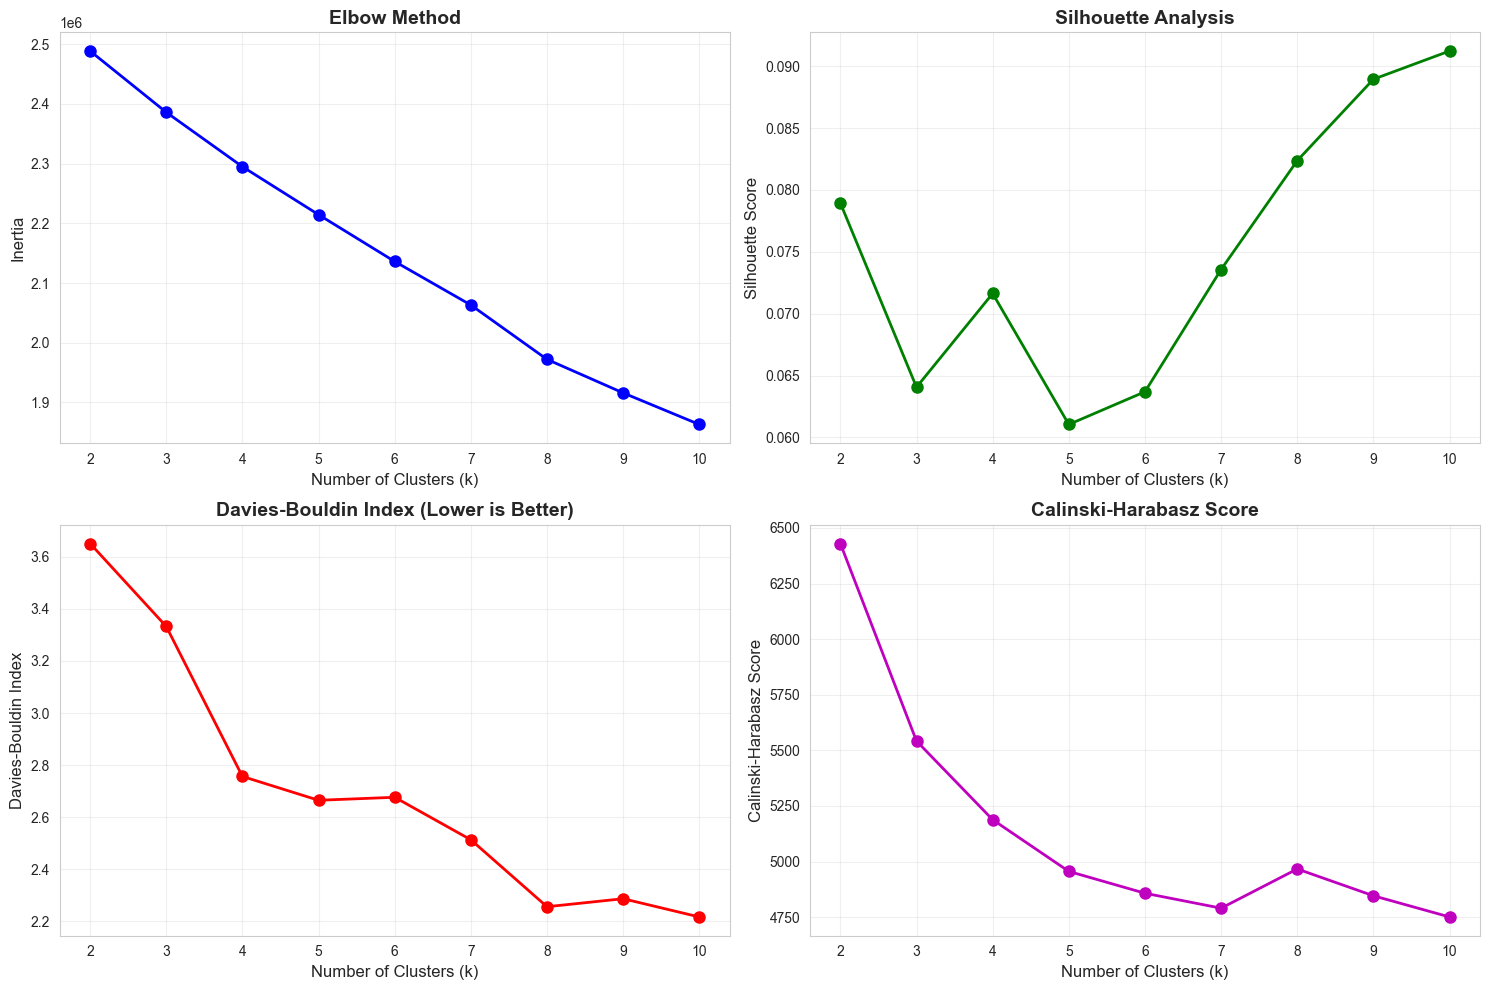


✅ Optimal k (by silhouette score): 10


In [33]:
# =========================
# 3. DATA PREPROCESSING
# =========================
print("\n" + "="*60)
print("PREPROCESSING")
print("="*60)

initial_rows = len(df_cluster)

# Fill missing values in all columns
for col in df_cluster.select_dtypes(include='object').columns:
    df_cluster[col].fillna(df_cluster[col].mode()[0], inplace=True)

for col in df_cluster.select_dtypes(exclude='object').columns:
    df_cluster[col].fillna(df_cluster[col].mean(), inplace=True)

print(f"Total missing values after filling: {df_cluster.isnull().sum().sum()}")

# Drop rows with missing values only in selected features (if any remain)
features_to_check = numeric_features + categorical_features + medication_features
df_cluster = df_cluster.dropna(subset=features_to_check)

print(f"Dropped {initial_rows - len(df_cluster)} rows with missing values in selected features")
print(f"Final dataset size: {df_cluster.shape}")
print(f"Retention rate: {len(df_cluster)/initial_rows*100:.1f}%")

# Separate features - FIXED: Use df_cluster instead of df
X_numeric = df_cluster[numeric_features].copy()
X_categorical = df_cluster[categorical_features].copy()
X_medications = df_cluster[medication_features].copy()

# =========================
# 4. ENCODE CATEGORICAL FEATURES
# =========================
print("\n" + "="*60)
print("ENCODING FEATURES")
print("="*60)

# Label encoding for categorical features
X_categorical_encoded = X_categorical.copy()
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col].astype(str))
    label_encoders[col] = le

# Label encoding for medication features
X_medications_encoded = X_medications.copy()
for col in medication_features:
    le = LabelEncoder()
    X_medications_encoded[col] = le.fit_transform(X_medications[col].astype(str))
    label_encoders[col] = le

# Combine all features
X_combined = pd.concat([X_numeric, X_categorical_encoded, X_medications_encoded], axis=1)
print(f"Combined feature matrix: {X_combined.shape}")

# =========================
# 5. SCALE FEATURES
# =========================
print("\n" + "="*60)
print("SCALING FEATURES")
print("="*60)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)
print(f"Scaled data shape: {X_scaled.shape}")

# =========================
# 6. FIND OPTIMAL NUMBER OF CLUSTERS
# =========================
print("\n" + "="*60)
print("FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*60)

k_range = range(2, 11)
inertias = []
silhouette_scores_list = []
davies_bouldin_scores = []
calinski_scores = []

print("\nEvaluating different k values...")
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores_list.append(silhouette_score(X_scaled, labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_scaled, labels))
    calinski_scores.append(calinski_harabasz_score(X_scaled, labels))
    
    print(f"k={k}: Silhouette={silhouette_scores_list[-1]:.3f}, "
          f"Davies-Bouldin={davies_bouldin_scores[-1]:.3f}, "
          f"Calinski-Harabasz={calinski_scores[-1]:.1f}")

# Plot evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Elbow plot
axes[0, 0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 0].set_ylabel('Inertia', fontsize=12)
axes[0, 0].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette score
axes[0, 1].plot(k_range, silhouette_scores_list, 'go-', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12)
axes[0, 1].set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Davies-Bouldin index
axes[1, 0].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 0].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Calinski-Harabasz score
axes[1, 1].plot(k_range, calinski_scores, 'mo-', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1, 1].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[1, 1].set_title('Calinski-Harabasz Score', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine optimal k
optimal_k = k_range[np.argmax(silhouette_scores_list)]
print(f"\n✅ Optimal k (by silhouette score): {optimal_k}")

In [35]:
# =========================
# 7. APPLY K-MEANS CLUSTERING
# =========================
optimal_k = 4
print("\n" + "="*60)
print(f"APPLYING K-MEANS (k={optimal_k})")
print("="*60)

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to df_cluster (not df)
df_cluster['kmeans_cluster'] = kmeans_labels

print(f"\nK-Means cluster distribution:")
print(df_cluster['kmeans_cluster'].value_counts().sort_index())

print(f"\nCluster percentages:")
cluster_pcts = df_cluster['kmeans_cluster'].value_counts(normalize=True).sort_index() * 100
for cluster, pct in cluster_pcts.items():
    print(f"  Cluster {cluster}: {pct:.2f}%")

# Calculate cluster sizes
cluster_sizes = df_cluster['kmeans_cluster'].value_counts().sort_index()
print(f"\nCluster sizes:")
for cluster, size in cluster_sizes.items():
    print(f"  Cluster {cluster}: {size:,} patients")


APPLYING K-MEANS (k=4)

K-Means cluster distribution:
kmeans_cluster
0    31997
1    44904
2    23371
3     1494
Name: count, dtype: int64

Cluster percentages:
  Cluster 0: 31.44%
  Cluster 1: 44.12%
  Cluster 2: 22.97%
  Cluster 3: 1.47%

Cluster sizes:
  Cluster 0: 31,997 patients
  Cluster 1: 44,904 patients
  Cluster 2: 23,371 patients
  Cluster 3: 1,494 patients



APPLYING HIERARCHICAL CLUSTERING (k=4)
⚠️  Large dataset detected (101,766 samples)
Using stratified sample of 5,000 samples for hierarchical clustering
Sample created: (5000, 26)

Testing different linkage methods on sample...
  Linkage: ward       | Silhouette: 0.0214
  Linkage: complete   | Silhouette: 0.6644
  Linkage: average    | Silhouette: 0.6644

✅ Best linkage method: complete

Hierarchical cluster distribution (on sample):
0    4995
1       1
2       3
3       1
Name: count, dtype: int64

Cluster percentages (on sample):
  Cluster 0: 99.90%
  Cluster 1: 0.02%
  Cluster 2: 0.06%
  Cluster 3: 0.02%

CREATING DENDROGRAM
Using 500 samples for dendrogram visualization...


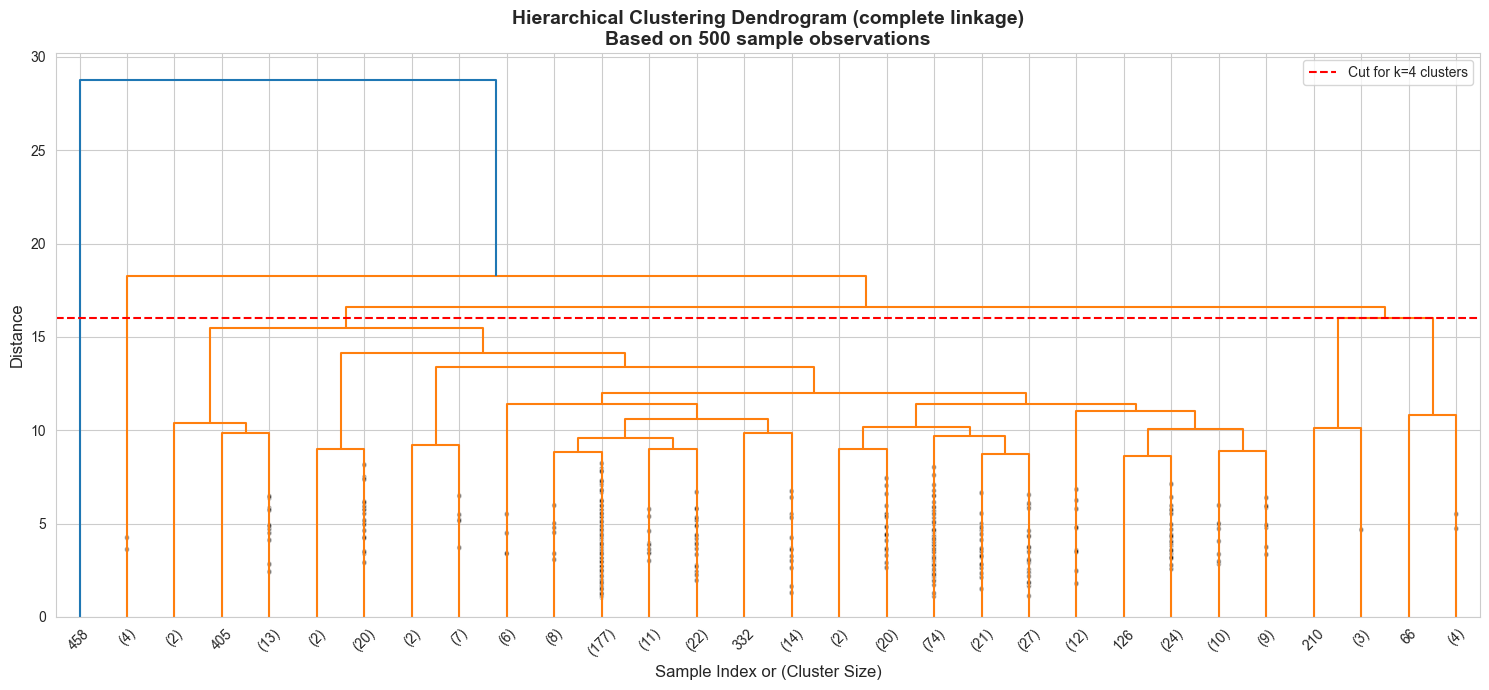


COMPARING K-MEANS VS HIERARCHICAL (ON SAMPLE)

Adjusted Rand Index: -0.0001
Normalized Mutual Information: 0.0012

Interpretation:
  ⚠️  Low agreement - significant differences between methods

CLUSTER MAPPING (K-means vs Hierarchical on sample)
Hierarchical     0  1  2  3   All
K-means                          
0             1572  0  0  0  1572
1             2203  1  2  0  2206
2             1146  0  1  1  1148
3               74  0  0  0    74
All           4995  1  3  1  5000

✅ Hierarchical clustering complete!
Note: Results based on stratified sample of 5,000 patients


In [37]:
# =========================
# 8. APPLY HIERARCHICAL CLUSTERING (ON SAMPLE)
# =========================
print("\n" + "="*60)
print(f"APPLYING HIERARCHICAL CLUSTERING (k={optimal_k})")
print("="*60)

# CRITICAL: Use a sample for hierarchical clustering to avoid memory issues
hier_sample_size = 5000  # Adjust based on your RAM (5000 is safe)
print(f"⚠️  Large dataset detected ({len(X_scaled):,} samples)")
print(f"Using stratified sample of {hier_sample_size:,} samples for hierarchical clustering")

# Create stratified sample based on K-means clusters for representativeness
from sklearn.model_selection import train_test_split

np.random.seed(42)
X_hier_sample, _, kmeans_sample, _ = train_test_split(
    X_scaled, 
    kmeans_labels,
    train_size=hier_sample_size,
    stratify=kmeans_labels,
    random_state=42
)

print(f"Sample created: {X_hier_sample.shape}")

# Try different linkage methods on the sample
linkage_methods = ['ward', 'complete', 'average']
hierarchical_results = {}

print("\nTesting different linkage methods on sample...")
for method in linkage_methods:
    hier = AgglomerativeClustering(n_clusters=optimal_k, linkage=method)
    hier_labels_sample = hier.fit_predict(X_hier_sample)
    silhouette = silhouette_score(X_hier_sample, hier_labels_sample)
    
    hierarchical_results[method] = {
        'labels': hier_labels_sample,
        'silhouette': silhouette,
        'model': hier
    }
    
    print(f"  Linkage: {method:10s} | Silhouette: {silhouette:.4f}")

# Use best method
best_linkage = max(hierarchical_results, key=lambda x: hierarchical_results[x]['silhouette'])
hier_labels_sample = hierarchical_results[best_linkage]['labels']

print(f"\n✅ Best linkage method: {best_linkage}")
print(f"\nHierarchical cluster distribution (on sample):")
print(pd.Series(hier_labels_sample).value_counts().sort_index())

print(f"\nCluster percentages (on sample):")
cluster_pcts = pd.Series(hier_labels_sample).value_counts(normalize=True).sort_index() * 100
for cluster, pct in cluster_pcts.items():
    print(f"  Cluster {cluster}: {pct:.2f}%")

# =========================
# Create dendrogram
# =========================
print("\n" + "="*60)
print("CREATING DENDROGRAM")
print("="*60)

# Use even smaller sample for dendrogram (for visualization clarity)
dendrogram_sample_size = min(500, len(X_hier_sample))
np.random.seed(42)
sample_indices = np.random.choice(len(X_hier_sample), dendrogram_sample_size, replace=False)
X_dend_sample = X_hier_sample[sample_indices]

print(f"Using {dendrogram_sample_size} samples for dendrogram visualization...")

# Calculate linkage matrix
linkage_matrix = linkage(X_dend_sample, method=best_linkage)

plt.figure(figsize=(15, 7))
dendrogram(
    linkage_matrix, 
    truncate_mode='lastp', 
    p=30,
    leaf_font_size=10,
    show_contracted=True
)
plt.xlabel('Sample Index or (Cluster Size)', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.title(f'Hierarchical Clustering Dendrogram ({best_linkage} linkage)\n'
          f'Based on {dendrogram_sample_size} sample observations', 
          fontsize=14, fontweight='bold')
plt.axhline(y=linkage_matrix[-optimal_k, 2], color='r', linestyle='--', 
            label=f'Cut for k={optimal_k} clusters')
plt.legend()
plt.tight_layout()
plt.show()

# =========================
# Compare K-means vs Hierarchical (on sample)
# =========================
print("\n" + "="*60)
print("COMPARING K-MEANS VS HIERARCHICAL (ON SAMPLE)")
print("="*60)

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

ari = adjusted_rand_score(kmeans_sample, hier_labels_sample)
nmi = normalized_mutual_info_score(kmeans_sample, hier_labels_sample)

print(f"\nAdjusted Rand Index: {ari:.4f}")
print(f"Normalized Mutual Information: {nmi:.4f}")
print("\nInterpretation:")
if ari > 0.8:
    print("  ✅ Very high agreement - clustering methods are very consistent")
elif ari > 0.6:
    print("  ✅ Good agreement - clustering methods are fairly consistent")
elif ari > 0.4:
    print("  ⚠️  Moderate agreement - some differences between methods")
else:
    print("  ⚠️  Low agreement - significant differences between methods")

# Cross-tabulation on sample
print("\n" + "="*60)
print("CLUSTER MAPPING (K-means vs Hierarchical on sample)")
print("="*60)
crosstab = pd.crosstab(
    pd.Series(kmeans_sample, name='K-means'), 
    pd.Series(hier_labels_sample, name='Hierarchical'),
    margins=True
)
print(crosstab)

print(f"\n✅ Hierarchical clustering complete!")
print(f"Note: Results based on stratified sample of {hier_sample_size:,} patients")

In [38]:
# =========================
# 9. APPLY DBSCAN
# =========================
print("\n" + "="*60)
print("APPLYING DBSCAN")
print("="*60)

# Test different eps values
eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
dbscan_results = {}

print("Testing different eps values...")
for eps in eps_values:
    dbscan = DBSCAN(eps=eps, min_samples=5, n_jobs=-1)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    
    n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
    n_noise = np.sum(dbscan_labels == -1)
    
    # Calculate silhouette only if there are 2+ clusters and not all points are noise
    if n_clusters > 1 and n_noise < len(dbscan_labels):
        # Exclude noise points for silhouette calculation
        non_noise_mask = dbscan_labels != -1
        if np.sum(non_noise_mask) > 0:
            try:
                silhouette = silhouette_score(X_scaled[non_noise_mask], dbscan_labels[non_noise_mask])
            except:
                silhouette = np.nan
        else:
            silhouette = np.nan
    else:
        silhouette = np.nan
    
    dbscan_results[eps] = {
        'labels': dbscan_labels,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'pct_noise': n_noise / len(dbscan_labels) * 100,
        'silhouette': silhouette
    }
    
    print(f"  eps={eps}: {n_clusters:2d} clusters, "
          f"{n_noise:6,} noise points ({n_noise/len(dbscan_labels)*100:5.1f}%), "
          f"Silhouette: {silhouette:.3f}" if not np.isnan(silhouette) else f"  eps={eps}: {n_clusters:2d} clusters, {n_noise:6,} noise points ({n_noise/len(dbscan_labels)*100:5.1f}%), Silhouette: N/A")

# Choose eps with reasonable noise level (5-15%) and good cluster count
print("\n" + "="*60)
print("SELECTING OPTIMAL EPS")
print("="*60)

# Find eps with reasonable clusters and noise percentage
candidates = {eps: info for eps, info in dbscan_results.items() 
              if info['n_clusters'] > 1 and 5 <= info['pct_noise'] <= 20}

if candidates:
    # Choose based on best silhouette among candidates
    optimal_eps = max(candidates, key=lambda x: candidates[x].get('silhouette', -1) 
                      if not np.isnan(candidates[x].get('silhouette', -1)) else -1)
else:
    # Fallback: choose eps with closest to 10% noise
    optimal_eps = min(dbscan_results, key=lambda x: abs(dbscan_results[x]['pct_noise'] - 10))

dbscan_labels = dbscan_results[optimal_eps]['labels']

# Add to df_cluster (not df)
df_cluster['dbscan_cluster'] = dbscan_labels

print(f"\n✅ Selected eps={optimal_eps}")
print(f"   Clusters: {dbscan_results[optimal_eps]['n_clusters']}")
print(f"   Noise points: {dbscan_results[optimal_eps]['n_noise']:,} ({dbscan_results[optimal_eps]['pct_noise']:.1f}%)")
if not np.isnan(dbscan_results[optimal_eps]['silhouette']):
    print(f"   Silhouette Score: {dbscan_results[optimal_eps]['silhouette']:.4f}")

# Show cluster distribution
print(f"\nDBSCAN cluster distribution:")
cluster_counts = pd.Series(dbscan_labels).value_counts().sort_index()
print(cluster_counts)

print(f"\nCluster percentages:")
for cluster, count in cluster_counts.items():
    pct = count / len(dbscan_labels) * 100
    if cluster == -1:
        print(f"  Noise (-1): {pct:.2f}%")
    else:
        print(f"  Cluster {cluster}: {pct:.2f}%")

print(f"\n✅ DBSCAN clustering complete!")


APPLYING DBSCAN
Testing different eps values...
  eps=0.5: 77 clusters, 101,086 noise points ( 99.3%), Silhouette: 0.329
  eps=1.0: 364 clusters, 85,225 noise points ( 83.7%), Silhouette: -0.125
  eps=1.5: 359 clusters, 54,801 noise points ( 53.9%), Silhouette: -0.121
  eps=2.0: 330 clusters, 29,482 noise points ( 29.0%), Silhouette: -0.040
  eps=2.5: 160 clusters, 15,677 noise points ( 15.4%), Silhouette: -0.041

SELECTING OPTIMAL EPS

✅ Selected eps=2.5
   Clusters: 160
   Noise points: 15,677 (15.4%)
   Silhouette Score: -0.0413

DBSCAN cluster distribution:
-1      15677
 0      53921
 1       7040
 2       2544
 3       5972
        ...  
 155        5
 156        5
 157        5
 158        4
 159        6
Name: count, Length: 161, dtype: int64

Cluster percentages:
  Noise (-1): 15.40%
  Cluster 0: 52.99%
  Cluster 1: 6.92%
  Cluster 2: 2.50%
  Cluster 3: 5.87%
  Cluster 4: 2.47%
  Cluster 5: 0.23%
  Cluster 6: 1.68%
  Cluster 7: 2.62%
  Cluster 8: 0.01%
  Cluster 9: 0.11%
  Cl


PCA DIMENSIONALITY REDUCTION
Total features: 26
Total components: 26


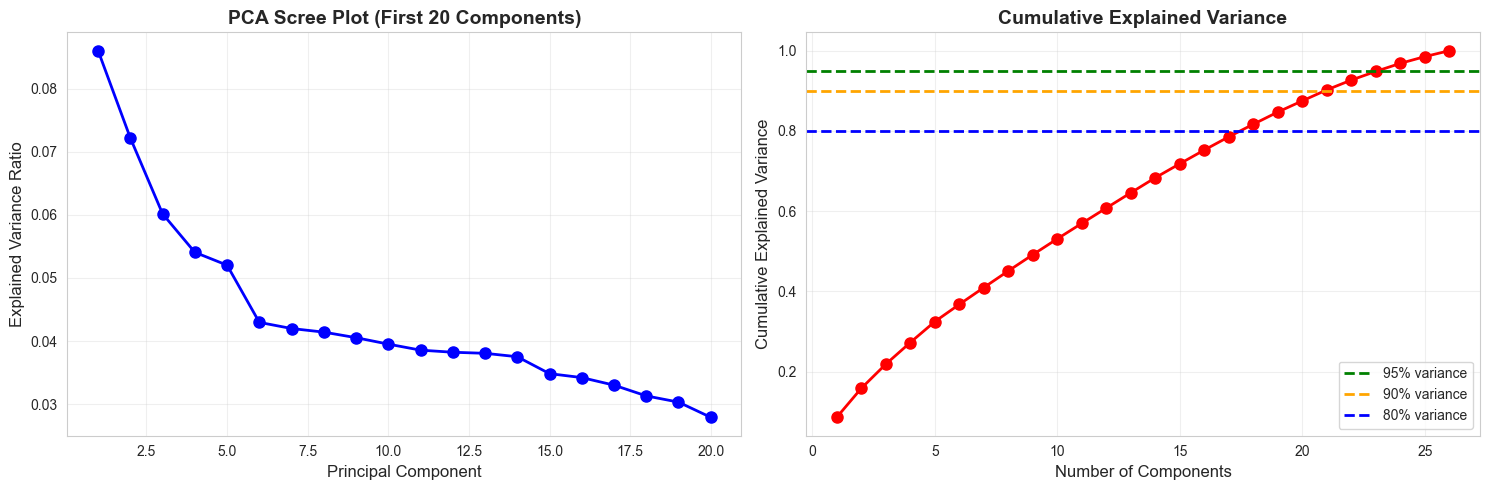


VARIANCE EXPLAINED BY COMPONENTS
Components for 80% variance: 18
Components for 90% variance: 21
Components for 95% variance: 24

First 2 components: 15.82%
First 3 components: 21.84%
First 5 components: 32.45%
First 10 components: 53.09%

TOP 5 PRINCIPAL COMPONENTS
PC1: 0.0860 (8.60%)
PC2: 0.0722 (7.22%)
PC3: 0.0602 (6.02%)
PC4: 0.0541 (5.41%)
PC5: 0.0520 (5.20%)

REDUCING TO 2D AND 3D FOR VISUALIZATION

2D PCA explains: 15.82% of total variance
  - PC1: 8.60%
  - PC2: 7.22%

3D PCA explains: 21.84% of total variance
  - PC1: 8.60%
  - PC2: 7.22%
  - PC3: 6.02%

✅ PCA dimensionality reduction complete!
   Original dimensions: 26
   Reduced to 2D and 3D for visualization


In [39]:
# =========================
# 10. PCA DIMENSIONALITY REDUCTION
# =========================
print("\n" + "="*60)
print("PCA DIMENSIONALITY REDUCTION")
print("="*60)

# Full PCA to see variance explained
pca_full = PCA()
pca_full.fit(X_scaled)

print(f"Total features: {X_scaled.shape[1]}")
print(f"Total components: {len(pca_full.explained_variance_ratio_)}")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Scree plot
axes[0].plot(range(1, min(21, len(pca_full.explained_variance_ratio_) + 1)), 
             pca_full.explained_variance_ratio_[:20], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Principal Component', fontsize=12)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12)
axes[0].set_title('PCA Scree Plot (First 20 Components)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Cumulative variance
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
axes[1].plot(range(1, len(cumsum) + 1), cumsum, 'ro-', linewidth=2, markersize=8)
axes[1].axhline(y=0.95, color='green', linestyle='--', linewidth=2, label='95% variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', linewidth=2, label='90% variance')
axes[1].axhline(y=0.80, color='blue', linestyle='--', linewidth=2, label='80% variance')
axes[1].set_xlabel('Number of Components', fontsize=12)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12)
axes[1].set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Variance thresholds
n_components_80 = np.argmax(cumsum >= 0.80) + 1
n_components_90 = np.argmax(cumsum >= 0.90) + 1
n_components_95 = np.argmax(cumsum >= 0.95) + 1

print(f"\n{'='*50}")
print("VARIANCE EXPLAINED BY COMPONENTS")
print(f"{'='*50}")
print(f"Components for 80% variance: {n_components_80}")
print(f"Components for 90% variance: {n_components_90}")
print(f"Components for 95% variance: {n_components_95}")
print(f"\nFirst 2 components: {cumsum[1]:.2%}")
print(f"First 3 components: {cumsum[2]:.2%}")
print(f"First 5 components: {cumsum[4]:.2%}")
print(f"First 10 components: {cumsum[9]:.2%}")

# Individual component contributions
print(f"\n{'='*50}")
print("TOP 5 PRINCIPAL COMPONENTS")
print(f"{'='*50}")
for i in range(min(5, len(pca_full.explained_variance_ratio_))):
    print(f"PC{i+1}: {pca_full.explained_variance_ratio_[i]:.4f} ({pca_full.explained_variance_ratio_[i]*100:.2f}%)")

# Apply PCA for visualization (2D and 3D)
print(f"\n{'='*50}")
print("REDUCING TO 2D AND 3D FOR VISUALIZATION")
print(f"{'='*50}")

pca_2d = PCA(n_components=2, random_state=42)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3, random_state=42)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# Store in df_cluster
df_cluster['pca_1'] = X_pca_2d[:, 0]
df_cluster['pca_2'] = X_pca_2d[:, 1]
df_cluster['pca_3'] = X_pca_3d[:, 2]  # Store 3rd component too

print(f"\n2D PCA explains: {pca_2d.explained_variance_ratio_.sum():.2%} of total variance")
print(f"  - PC1: {pca_2d.explained_variance_ratio_[0]:.2%}")
print(f"  - PC2: {pca_2d.explained_variance_ratio_[1]:.2%}")

print(f"\n3D PCA explains: {pca_3d.explained_variance_ratio_.sum():.2%} of total variance")
print(f"  - PC1: {pca_3d.explained_variance_ratio_[0]:.2%}")
print(f"  - PC2: {pca_3d.explained_variance_ratio_[1]:.2%}")
print(f"  - PC3: {pca_3d.explained_variance_ratio_[2]:.2%}")

print(f"\n✅ PCA dimensionality reduction complete!")
print(f"   Original dimensions: {X_scaled.shape[1]}")
print(f"   Reduced to 2D and 3D for visualization")

In [42]:
# =========================
# 11. t-SNE DIMENSIONALITY REDUCTION
# =========================
print("\n" + "="*60)
print("t-SNE DIMENSIONALITY REDUCTION")
print("="*60)

# t-SNE on sample (it's slow on large datasets)
sample_size_tsne = min(10000, len(X_scaled))
print(f"Dataset size: {len(X_scaled):,} samples")
print(f"Using sample size: {sample_size_tsne:,} for t-SNE")

# Create stratified sample based on K-means clusters for better representation
np.random.seed(42)
if sample_size_tsne < len(X_scaled):
    from sklearn.model_selection import train_test_split
    
    X_sample_tsne, _, kmeans_sample, _, sample_indices_tsne, _ = train_test_split(
        X_scaled, 
        kmeans_labels,
        np.arange(len(X_scaled)),
        train_size=sample_size_tsne,
        stratify=kmeans_labels,
        random_state=42
    )
    print("Using stratified sample (maintains cluster proportions)")
else:
    X_sample_tsne = X_scaled
    kmeans_sample = kmeans_labels
    sample_indices_tsne = np.arange(len(X_scaled))
    print("Using full dataset")

# Get other cluster labels for the sample
hier_sample = None
dbscan_sample = None

if 'hierarchical_cluster' in df_cluster.columns:
    hier_sample = df_cluster['hierarchical_cluster'].iloc[sample_indices_tsne].values

if 'dbscan_cluster' in df_cluster.columns:
    dbscan_sample = df_cluster['dbscan_cluster'].iloc[sample_indices_tsne].values

print(f"\nRunning t-SNE (this may take 1-3 minutes)...")
print(f"Parameters: perplexity=30, max_iter=1000")

import time
start_time = time.time()

# FIXED: Use max_iter instead of n_iter
tsne = TSNE(
    n_components=2, 
    random_state=42, 
    perplexity=30, 
    max_iter=1000,  # Changed from n_iter
    verbose=1
)
X_tsne = tsne.fit_transform(X_sample_tsne)

elapsed_time = time.time() - start_time
print(f"\n✅ t-SNE complete in {elapsed_time:.1f} seconds")

# Store t-SNE results
tsne_results = {
    'X_tsne': X_tsne,
    'sample_indices': sample_indices_tsne,
    'kmeans_labels': kmeans_sample,
    'hier_labels': hier_sample,
    'dbscan_labels': dbscan_sample
}

print(f"t-SNE embedding shape: {X_tsne.shape}")
print(f"Sample represents {sample_size_tsne/len(X_scaled)*100:.1f}% of data")


t-SNE DIMENSIONALITY REDUCTION
Dataset size: 101,766 samples
Using sample size: 10,000 for t-SNE
Using stratified sample (maintains cluster proportions)

Running t-SNE (this may take 1-3 minutes)...
Parameters: perplexity=30, max_iter=1000
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.000s...
[t-SNE] Computed neighbors for 10000 samples in 0.777s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Compu

In [43]:
# =========================
# 12. UMAP DIMENSIONALITY REDUCTION (Optional)
# =========================
if UMAP_AVAILABLE:
    print("\n" + "="*60)
    print("UMAP DIMENSIONALITY REDUCTION")
    print("="*60)
    
    print(f"Running UMAP on {sample_size_tsne:,} samples...")
    print(f"Parameters: n_neighbors=15, min_dist=0.1")
    
    import time
    start_time = time.time()
    
    umap_model = UMAP(
        n_components=2, 
        random_state=42, 
        n_neighbors=15, 
        min_dist=0.1,
        verbose=True  # Show progress
    )
    X_umap = umap_model.fit_transform(X_sample_tsne)
    
    elapsed_time = time.time() - start_time
    print(f"\n✅ UMAP complete in {elapsed_time:.1f} seconds")
    
    # Store UMAP results
    umap_results = {
        'X_umap': X_umap,
        'sample_indices': sample_indices_tsne,
        'kmeans_labels': kmeans_sample,
        'hier_labels': hier_sample,
        'dbscan_labels': dbscan_sample
    }
    
    print(f"UMAP embedding shape: {X_umap.shape}")
    print(f"Sample represents {sample_size_tsne/len(X_scaled)*100:.1f}% of data")
    
else:
    print("\n" + "="*60)
    print("UMAP DIMENSIONALITY REDUCTION")
    print("="*60)
    print("⚠️  UMAP not available. Skipping...")
    print("To install: pip install umap-learn")
    X_umap = None
    umap_results = None


UMAP DIMENSIONALITY REDUCTION
Running UMAP on 10,000 samples...
Parameters: n_neighbors=15, min_dist=0.1
UMAP(n_jobs=1, random_state=42, verbose=True)
Sun Nov  2 21:34:02 2025 Construct fuzzy simplicial set
Sun Nov  2 21:34:02 2025 Finding Nearest Neighbors
Sun Nov  2 21:34:02 2025 Building RP forest with 10 trees
Sun Nov  2 21:34:02 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	Stopping threshold met -- exiting after 4 iterations
Sun Nov  2 21:34:03 2025 Finished Nearest Neighbor Search
Sun Nov  2 21:34:03 2025 Construct embedding


Epochs completed:   2%| ▏          12/500 [00:00]

	completed  0  /  500 epochs


Epochs completed:  11%| █          55/500 [00:01]

	completed  50  /  500 epochs


Epochs completed:  21%| ██         106/500 [00:02]

	completed  100  /  500 epochs


Epochs completed:  31%| ███        154/500 [00:04]

	completed  150  /  500 epochs


Epochs completed:  41%| ████       206/500 [00:07]

	completed  200  /  500 epochs


Epochs completed:  51%| █████      254/500 [00:09]

	completed  250  /  500 epochs


Epochs completed:  62%| ██████▏    309/500 [00:10]

	completed  300  /  500 epochs


Epochs completed:  71%| ███████    354/500 [00:12]

	completed  350  /  500 epochs


Epochs completed:  81%| ████████▏  407/500 [00:13]

	completed  400  /  500 epochs


Epochs completed:  91%| █████████  454/500 [00:15]

	completed  450  /  500 epochs


Epochs completed: 100%| ██████████ 500/500 [00:16]

Sun Nov  2 21:34:21 2025 Finished embedding

✅ UMAP complete in 19.3 seconds
UMAP embedding shape: (10000, 2)
Sample represents 9.8% of data



VISUALIZING CLUSTERS
⚠️  Hierarchical clustering not available (ran on sample only)


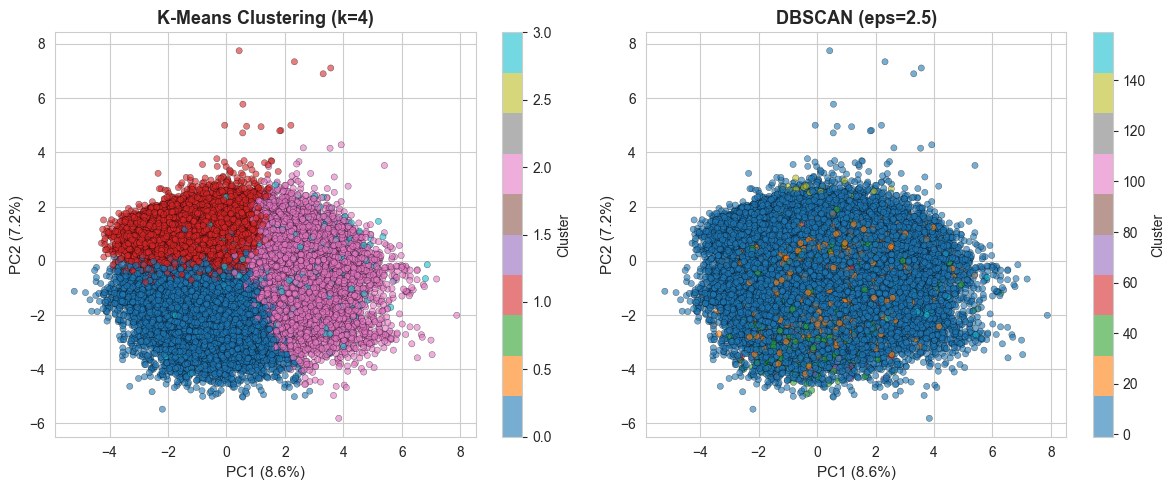

✅ Cluster visualization complete (2 method(s) shown)

COMPARING DIMENSIONALITY REDUCTION METHODS


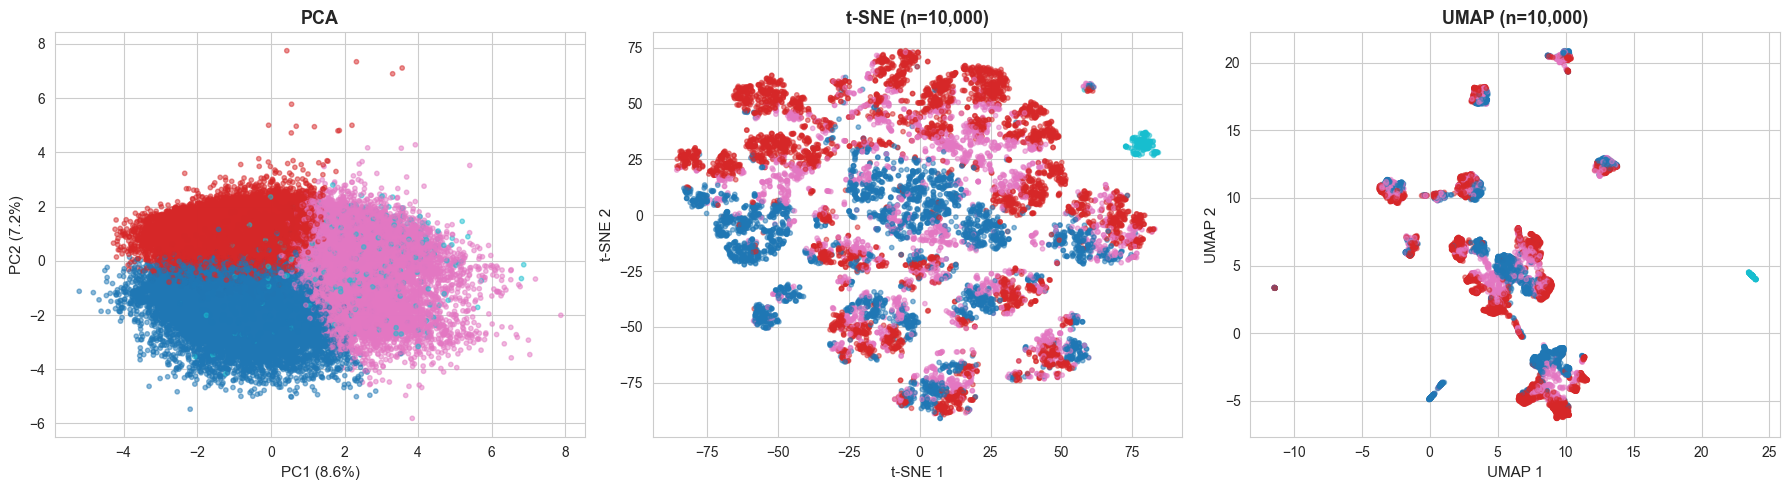

✅ Dimensionality reduction comparison complete

3D PCA VISUALIZATION


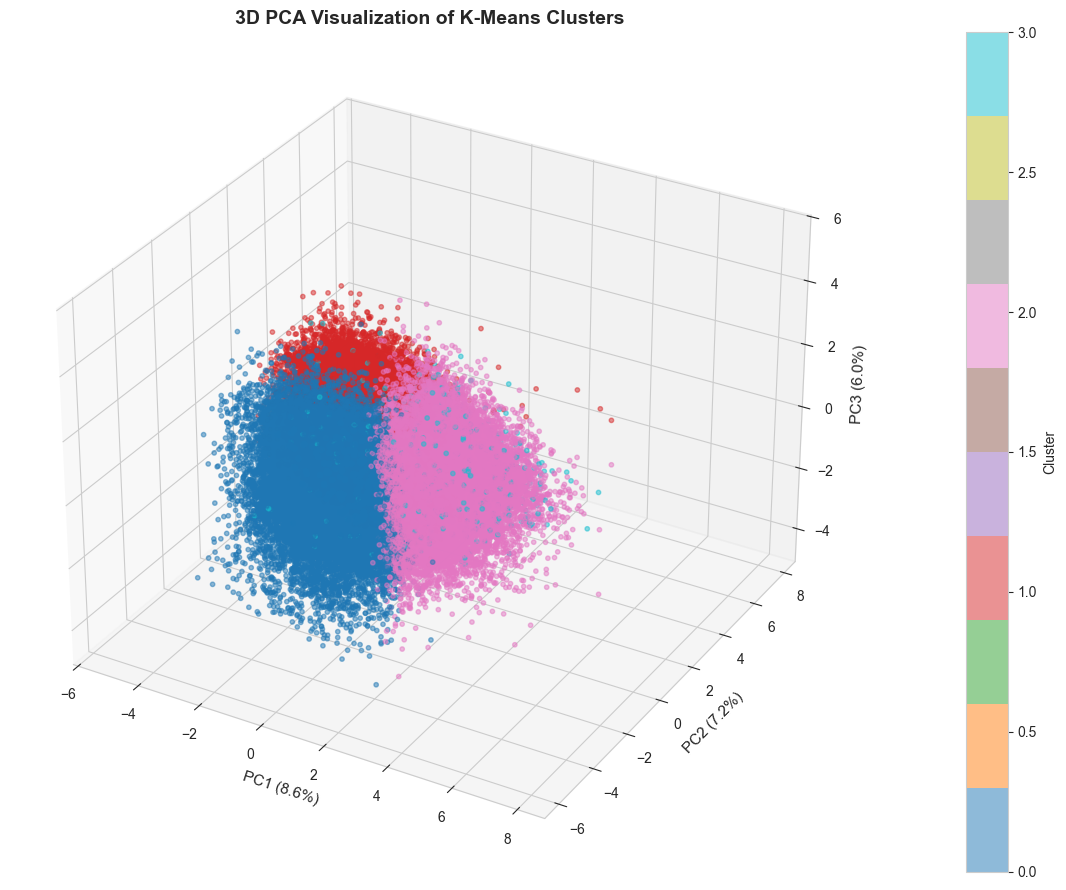

✅ 3D visualization complete

CLUSTER PROFILING (K-MEANS)

CLUSTER 0 (n=31,997, 31.4%)

Numeric Features:
  time_in_hospital         : mean=  3.42, median=  3.00 (diff:  -22.1%)
  num_lab_procedures       : mean= 33.38, median= 34.00 (diff:  -22.5%)
  num_procedures           : mean=  1.54, median=  1.00 (diff:  +15.1%)
  num_medications          : mean= 14.85, median= 14.00 (diff:   -7.3%)
  number_outpatient        : mean=  0.42, median=  0.00 (diff:  +12.9%)
  number_emergency         : mean=  0.13, median=  0.00 (diff:  -35.2%)
  number_inpatient         : mean=  0.47, median=  0.00 (diff:  -26.6%)
  number_diagnoses         : mean=  6.82, median=  7.00 (diff:   -8.1%)

Readmission Distribution:
  NO: 18,349 (57.3%)
  >30: 10,521 (32.9%)
  <30: 3,127 (9.8%)

CLUSTER 1 (n=44,904, 44.1%)

Numeric Features:
  time_in_hospital         : mean=  3.22, median=  3.00 (diff:  -26.8%)
  num_lab_procedures       : mean= 42.84, median= 44.00 (diff:   -0.6%)
  num_procedures           : mean=  0

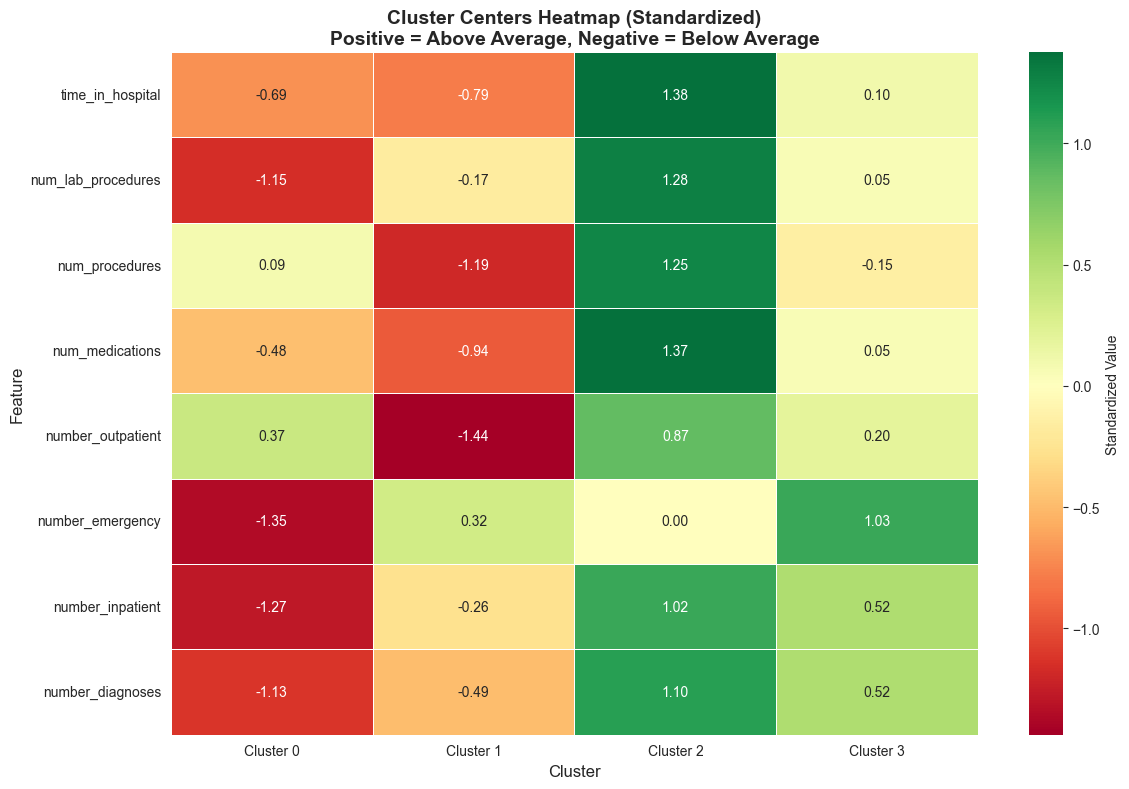

✅ Cluster heatmap complete

CLUSTERING ANALYSIS COMPLETE

📊 Dataset: 101,766 patients
📊 Features: 8 numeric + 9 categorical + 9 medications

🎯 Optimal k: 4
🎯 K-Means clusters: 4
🎯 Hierarchical: Ran on sample only (memory constraints)
🎯 DBSCAN clusters: 160 (15,677 noise points)

✅ All visualizations and profiling complete!


In [45]:
# =========================
# 13. VISUALIZE CLUSTERS WITH DIFFERENT METHODS
# =========================
print("\n" + "="*60)
print("VISUALIZING CLUSTERS")
print("="*60)

# Determine which clustering methods are available
has_hierarchical = 'hierarchical_cluster' in df_cluster.columns
has_dbscan = 'dbscan_cluster' in df_cluster.columns

# Count available methods
n_methods = 1 + (1 if has_hierarchical else 0) + (1 if has_dbscan else 0)

fig, axes = plt.subplots(1, n_methods, figsize=(6*n_methods, 5))

# Make axes always a list for consistent indexing
if n_methods == 1:
    axes = [axes]

plot_idx = 0

# K-Means (always available)
scatter1 = axes[plot_idx].scatter(df_cluster['pca_1'], df_cluster['pca_2'], 
                           c=df_cluster['kmeans_cluster'], 
                           cmap='tab10', alpha=0.6, s=20,
                           edgecolors='black', linewidth=0.3)
axes[plot_idx].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[plot_idx].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[plot_idx].set_title(f'K-Means Clustering (k={optimal_k})', fontsize=13, fontweight='bold')
plt.colorbar(scatter1, ax=axes[plot_idx], label='Cluster')
plot_idx += 1

# Hierarchical (if available)
if has_hierarchical:
    scatter2 = axes[plot_idx].scatter(df_cluster['pca_1'], df_cluster['pca_2'], 
                               c=df_cluster['hierarchical_cluster'], 
                               cmap='tab10', alpha=0.6, s=20,
                               edgecolors='black', linewidth=0.3)
    axes[plot_idx].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
    axes[plot_idx].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
    axes[plot_idx].set_title(f'Hierarchical Clustering ({best_linkage})', fontsize=13, fontweight='bold')
    plt.colorbar(scatter2, ax=axes[plot_idx], label='Cluster')
    plot_idx += 1
else:
    print("⚠️  Hierarchical clustering not available (ran on sample only)")

# DBSCAN (if available)
if has_dbscan:
    scatter3 = axes[plot_idx].scatter(df_cluster['pca_1'], df_cluster['pca_2'], 
                               c=df_cluster['dbscan_cluster'], 
                               cmap='tab10', alpha=0.6, s=20,
                               edgecolors='black', linewidth=0.3)
    axes[plot_idx].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
    axes[plot_idx].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
    axes[plot_idx].set_title(f'DBSCAN (eps={optimal_eps})', fontsize=13, fontweight='bold')
    plt.colorbar(scatter3, ax=axes[plot_idx], label='Cluster')
    plot_idx += 1

plt.tight_layout()
plt.show()

print(f"✅ Cluster visualization complete ({n_methods} method(s) shown)")

# =========================
# 14. COMPARE DIMENSIONALITY REDUCTION METHODS
# =========================
print("\n" + "="*60)
print("COMPARING DIMENSIONALITY REDUCTION METHODS")
print("="*60)

n_plots = 3 if UMAP_AVAILABLE else 2
fig, axes = plt.subplots(1, n_plots, figsize=(6*n_plots, 5))

if n_plots == 2:
    axes = [axes[0], axes[1]]

# PCA
scatter1 = axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                           c=kmeans_labels, cmap='tab10', alpha=0.5, s=10)
axes[0].set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]:.1%})', fontsize=11)
axes[0].set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]:.1%})', fontsize=11)
axes[0].set_title('PCA', fontsize=13, fontweight='bold')

# t-SNE
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                           c=kmeans_sample, cmap='tab10', alpha=0.5, s=10)
axes[1].set_xlabel('t-SNE 1', fontsize=11)
axes[1].set_ylabel('t-SNE 2', fontsize=11)
axes[1].set_title(f't-SNE (n={sample_size_tsne:,})', fontsize=13, fontweight='bold')

# UMAP
if UMAP_AVAILABLE:
    scatter3 = axes[2].scatter(X_umap[:, 0], X_umap[:, 1], 
                               c=kmeans_sample, cmap='tab10', alpha=0.5, s=10)
    axes[2].set_xlabel('UMAP 1', fontsize=11)
    axes[2].set_ylabel('UMAP 2', fontsize=11)
    axes[2].set_title(f'UMAP (n={sample_size_tsne:,})', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Dimensionality reduction comparison complete")

# =========================
# 15. 3D PCA VISUALIZATION
# =========================
print("\n" + "="*60)
print("3D PCA VISUALIZATION")
print("="*60)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                     c=kmeans_labels, cmap='tab10', alpha=0.5, s=10)

ax.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]:.1%})', fontsize=11)
ax.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]:.1%})', fontsize=11)
ax.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]:.1%})', fontsize=11)
ax.set_title('3D PCA Visualization of K-Means Clusters', fontsize=14, fontweight='bold')

plt.colorbar(scatter, ax=ax, label='Cluster', pad=0.1)
plt.tight_layout()
plt.show()

print("✅ 3D visualization complete")

# =========================
# 16. CLUSTER PROFILING
# =========================
print("\n" + "="*60)
print("CLUSTER PROFILING (K-MEANS)")
print("="*60)

for cluster_id in range(optimal_k):
    cluster_data = df_cluster[df_cluster['kmeans_cluster'] == cluster_id]
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id} (n={len(cluster_data):,}, {len(cluster_data)/len(df_cluster)*100:.1f}%)")
    print(f"{'='*60}")
    
    # Numeric features
    print("\nNumeric Features:")
    for feat in numeric_features:
        mean_val = cluster_data[feat].mean()
        median_val = cluster_data[feat].median()
        overall_mean = df_cluster[feat].mean()
        diff_pct = ((mean_val - overall_mean) / overall_mean) * 100 if overall_mean != 0 else 0
        print(f"  {feat:25s}: mean={mean_val:6.2f}, median={median_val:6.2f} (diff: {diff_pct:+6.1f}%)")
    
    # Readmission distribution
    if 'readmitted' in df_cluster.columns:
        print("\nReadmission Distribution:")
        readmit_dist = cluster_data['readmitted'].value_counts()
        for cat, count in readmit_dist.items():
            print(f"  {cat}: {count:,} ({count/len(cluster_data)*100:.1f}%)")

print("\n✅ Cluster profiling complete")

# =========================
# 17. CLUSTER COMPARISON HEATMAP
# =========================
print("\n" + "="*60)
print("CREATING CLUSTER HEATMAP")
print("="*60)

# Calculate cluster centers
cluster_centers = pd.DataFrame()
for cluster_id in range(optimal_k):
    cluster_data = df_cluster[df_cluster['kmeans_cluster'] == cluster_id]
    cluster_means = cluster_data[numeric_features].mean()
    cluster_centers[f'Cluster {cluster_id}'] = cluster_means

# Standardize for heatmap (z-scores across clusters for each feature)
cluster_centers_std = (cluster_centers.T - cluster_centers.mean(axis=1)) / cluster_centers.std(axis=1)
cluster_centers_std = cluster_centers_std.T

plt.figure(figsize=(12, 8))
sns.heatmap(cluster_centers_std, annot=True, fmt='.2f', cmap='RdYlGn', 
            center=0, cbar_kws={'label': 'Standardized Value'},
            linewidths=0.5)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Cluster Centers Heatmap (Standardized)\nPositive = Above Average, Negative = Below Average', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Cluster heatmap complete")

# =========================
# FINAL SUMMARY
# =========================
print("\n" + "="*60)
print("CLUSTERING ANALYSIS COMPLETE")
print("="*60)
print(f"\n📊 Dataset: {len(df_cluster):,} patients")
print(f"📊 Features: {len(numeric_features)} numeric + {len(categorical_features)} categorical + {len(medication_features)} medications")
print(f"\n🎯 Optimal k: {optimal_k}")
print(f"🎯 K-Means clusters: {df_cluster['kmeans_cluster'].nunique()}")

if has_hierarchical:
    print(f"🎯 Hierarchical clusters: {df_cluster['hierarchical_cluster'].nunique()}")
else:
    print(f"🎯 Hierarchical: Ran on sample only (memory constraints)")

if has_dbscan:
    n_dbscan_clusters = df_cluster['dbscan_cluster'].nunique() - (1 if -1 in df_cluster['dbscan_cluster'].values else 0)
    n_noise = (df_cluster['dbscan_cluster'] == -1).sum()
    print(f"🎯 DBSCAN clusters: {n_dbscan_clusters} ({n_noise:,} noise points)")

print(f"\n✅ All visualizations and profiling complete!")